In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from acquire import get_zillow_data
import wrangle

# What is Driving the Errors in the Zestimates?

# Acquire

In [2]:
df = get_zillow_data()

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (64) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Prepare

In [3]:
#Used handle missing valus function from program material. Columns must have min of 60% non-null values and rows min of 75% non-null or be dropped.
def handle_missing_values(df, prop_required_column = .60, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

#Function to remove unneeded columns. It will be used in wrangle function.
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [4]:
def wrangle_zillow(df):
    #Group by parcelid and transactiondate to finish filtering from Sql query.
    df = df[df.groupby('parcelid')['transactiondate'].transform('max') == df['transactiondate']]
    #Instead of filtering by unitcnt, filter using propertylanduse looking for single fam homes.
    df = df[df['propertylandusedesc'].isin(['Single Family Residential', 'Manufactured, Modular, Prefabricated Homes', 'Townhouse', 'Mobile Home ' ])]
    #Run handle missing values function
    df = handle_missing_values(df)
    #Change fips codes to county names
    df.loc[(df.fips == 6037.0),'fips']='Los Angeles County'
    df.loc[(df.fips == 6111.0),'fips']='Ventura County'
    df.loc[(df.fips == 6059.0),'fips']='Orange County'
    #Turn year built into a usable column
    df['age'] = 2020 - df['yearbuilt']
    #Reduce taxamount and value into a single column of tax percent
    df['tax_percentage'] = round(df['taxamount'] / df['taxvaluedollarcnt'],4)
    #Filter outliers
    df = df[df['bathroomcnt'] > 0]
    df = df[df['bedroomcnt'] > 0]
    df = df[df['bedroomcnt'] < 8]
    df = df[df['calculatedfinishedsquarefeet'] < 7000]
    #Remove unwanted columns including ids, redundant columns
    df = remove_columns(df, ['id','parcelid', 'roomcnt', 'propertylandusedesc','finishedsquarefeet12', 'regionidzip', 'heatingorsystemdesc', 'unitcnt','censustractandblock','calculatedbathnbr','fullbathcnt', 'regionidcity' , 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt','propertycountylandusecode', 'propertylandusetypeid', 'regionidcounty' , 'assessmentyear', 'propertyzoningdesc','transactiondate','heatingorsystemtypeid', 'buildingqualitytypeid','yearbuilt', 'taxamount', 'taxvaluedollarcnt' ])
    #Convert categorical column to dummies
    return df

In [5]:
df = wrangle_zillow(df)

In [6]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,logerror,age,tax_percentage
0,3.5,4.0,3100.0,Orange County,33634931.0,-117869207.0,4506.0,6.059063e+07,0.025595,22.0,0.0108
1,1.0,2.0,1465.0,Ventura County,34449266.0,-119281531.0,12647.0,6.111001e+07,0.055619,53.0,0.0122
2,2.0,3.0,1243.0,Orange County,33886168.0,-117823170.0,8432.0,6.059022e+07,0.005383,58.0,0.0115
3,3.0,4.0,2376.0,Los Angeles County,34245180.0,-118240722.0,13038.0,6.037300e+07,-0.103410,50.0,0.0122
6,3.0,4.0,2962.0,Los Angeles County,34145202.0,-118179824.0,63000.0,6.037461e+07,-0.001011,70.0,0.0123


# Explore

**Splitting the data**

In [8]:
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=42)
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  320320
validate observations:  137280
test observations:  114411


**Looking for differences in log error between Los Angeles, Ventura, and Orange Counties**

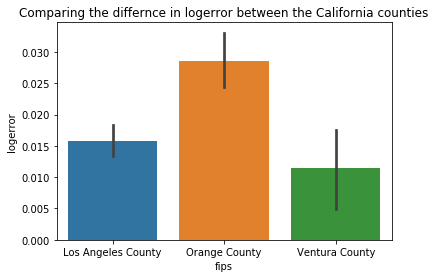

In [13]:
sns.barplot(data=train, x=train.fips, y=train.logerror)
plt.title('Comparing the differnce in logerror between the California counties')
plt.show()

**Running statistical tests**

In [10]:
ventura_logerror = train[train.fips == 'Ventura County'].logerror
los_angeles_logerror = train[train.fips == 'Los Angeles County'].logerror
orange_logerror = train[train.fips == 'Orange County'].logerror

**Testing for variance to determine type of test**

In [11]:
print(ventura_logerror.var())
print(los_angeles_logerror.var())
print(orange_logerror.var())

0.02461072408146452
0.027804356884529122
0.040756456786716355


**Variance is very similar and acceptable to run an Anova test**

In [14]:
alpha = .05
f, p = stats.f_oneway(ventura_logerror, los_angeles_logerror, orange_logerror)
print(f)
print(f'The p-value is {p}')
p < alpha

17.066051392736863
The p-value is 3.914252161072079e-08


True

**P-value is less than alpha. There is a significant difference in log error between the three counties**

________________________________________________________________________

**Going to analyze a few other independent variables in relation to log error**

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29120 entries, 54183 to 15139
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   29120 non-null  float64
 1   bedroomcnt                    29120 non-null  float64
 2   calculatedfinishedsquarefeet  29120 non-null  float64
 3   fips                          29120 non-null  object 
 4   latitude                      29120 non-null  float64
 5   longitude                     29120 non-null  float64
 6   lotsizesquarefeet             28913 non-null  float64
 7   rawcensustractandblock        29120 non-null  float64
 8   logerror                      29120 non-null  float64
 9   age                           29104 non-null  float64
 10  tax_percentage                29116 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.9+ MB


**Is there a correlation between tax percentage and log error?**

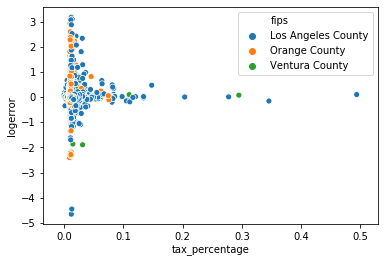

In [17]:
sns.scatterplot(data=train, x='tax_percentage', y='logerror', hue='fips')


In [18]:
train.tax_percentage.value_counts()

0.0121    1528
0.0122    1384
0.0123    1208
0.0120    1207
0.0124    1109
          ... 
0.0778       1
0.0372       1
0.0363       1
0.0856       1
0.0625       1
Name: tax_percentage, Length: 382, dtype: int64

In [19]:
train['tax_percent_bins'] = pd.cut(train.tax_percentage, [0, .015, .02, .03])


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


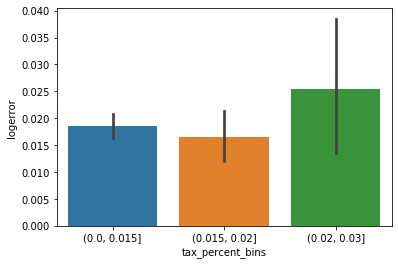

In [20]:
sns.barplot(train.tax_percent_bins, train.logerror)


**It appears people paying higher property taxes high a higher log error**

In [21]:
#Testing assumption of equal variance
stats.levene(train[train.tax_percentage <= .02].logerror, 
             train[train.tax_percentage > .02].logerror
            )

LeveneResult(statistic=25.2178032110539, pvalue=5.15095038197122e-07)

In [22]:
# Variance equals false

**Hypothesis is that there is not a significant difference between tax percentage and log error**

In [24]:
alpha = .05
t,p = stats.ttest_ind(train[train.tax_percentage <= .02].logerror, 
                train[train.tax_percentage > .02].logerror,
                equal_var=False
               )
p < alpha

True

**We reject the null. There is a significant difference in log error between between homes with a higher or lower tax percentage**

________________________________________________________________________

**Is there a correlation between calculatedfinishedsquarefeet and log error?**

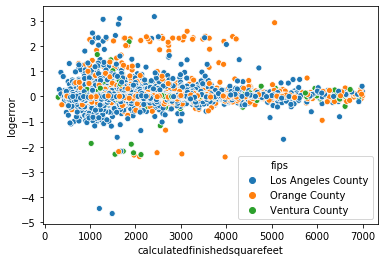

In [25]:
sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='logerror', hue='fips')


In [29]:
train['sqft_cut'] = pd.cut(train.calculatedfinishedsquarefeet, [0, 2500, 5000])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


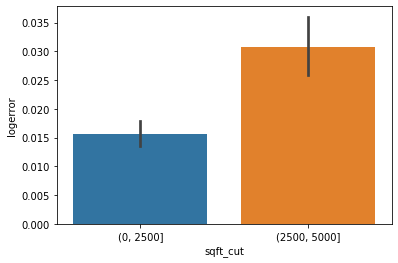

In [30]:
sns.barplot(train.sqft_cut, train.logerror)


In [26]:
#Testing assumption of equal variance
stats.levene(train[train.calculatedfinishedsquarefeet <= 2500].logerror, 
             train[train.calculatedfinishedsquarefeet > 2500].logerror
            )

LeveneResult(statistic=11.186089072896477, pvalue=0.0008251687565195057)

In [27]:
#Variance is False

In [28]:
alpha = .05
t,p = stats.ttest_ind(train[train.calculatedfinishedsquarefeet <= 2500].logerror, 
                train[train.calculatedfinishedsquarefeet > 2500].logerror,
                equal_var=False
               )
p < alpha

True

# Conclusions
**From looking at a few different variables, it looks like homes with higher square feet and a higher tax percentage both correlate to a higher log error**